In [92]:
# Kiley Huffman
# QBIO 482
# Assignment 5
# Due: Thursday, May 1

In the first two problems, we will consider two ways to simulate FRAP of fluorescent particles in two dimensions confined to a “square cell.”

Assume the square cell has sides of length 2L = 2 µm and that particles are initially uniformly distributed inside the cell (i.e. -L to L in both X and Y) at a concentration of 25 particles per squared micron with diffusion coefficients of 10 µm2/s. To model confinement of particles to the cell, we will use reflecting boundary conditions. We will model photobleaching as occurring in a smaller square region 2B=0.2 µm in the middle of the square cell (i.e., between −B and B in both X and Y , with B = 0.1 µm). Start by using a lattice spacing a = 10 nm (i.e. a square cell of 200x 200 lattice points). Note you can reconcile simulation time step, the lattice parameter, and the
diffusion coefficient through the relation D = a2/τ, where τ is the time step.

# 1. The first approach to simulating FRAP uses a random walker approach. [5pt each]

(a) Place walkers throughout the square cell except the photobleached region.

(b) Generate simulated random walk trajectories simultaneously for all of the walkers, making use of the reflecting boundary conditions so that random walkers cannot exit the square cell. Note that after one timestep, almost all the walkers would still be in the unbleached regions. Visualize these as line plots of 2D position over time.

(c) Generate a thousand simulated trajectories. Plot maps of fluorescent particle positions averaged across these simulations at t= 0 milliseconds (ms), 5 ms, 50 ms as a heatmap of average particle concentration per lattice site.

(d) Plot how the average concentration of fluorescent particles in the bleached region evolves as a function of time between 0 and 500 ms. Recall in 2D that concentration is the number of particles in an area.

(e) What happens at large times?

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# PARAMETERS
L = 1.0         # Half-length of box (microns), 2L = 2um
B = 0.1         # Half-length of bleach region (microns)
a = 0.01        # Lattice spacing (microns), a = 10nm 
D = 10.0        # Diffusion coefficient (micron^2/s)

# reconcile simulation time step, the lattice parameter, and the diffusion coefficient through the relation: 
tau = (a**2) / D  # tau = time step (seconds)
n_particles = 100
n_simulations = 1000

# Time settings
t_end = 0.5    # End time in seconds (500 ms)
n_steps = int(t_end / tau)
save_times_ms = [0, 5, 50]  # times to save for heatmaps
save_steps = [int(t * 1e-3 / tau) for t in save_times_ms]

# Grid for histograms
n_grid = 200 # cell of 200 x 200 lattice points
edges = np.linspace(-L, L, n_grid+1)

In [98]:
# Initialize all particles for all simulations
positions = np.zeros((n_simulations, n_particles, 2))

#  (a) Place walkers throughout the square cell except the photobleached region.
for sim in range(n_simulations):
    count = 0
    while count < n_particles:
        x = np.random.uniform(-L, L)
        y = np.random.uniform(-L, L)
        if not (-B <= x <= B and -B <= y <= B):
            positions[sim, count] = (x, y)
            count += 1

# Prepare to collect data
heatmaps = {t: np.zeros((n_grid, n_grid)) for t in save_times_ms}
bleach_counts = np.zeros((n_steps+1,))

In [19]:
# SIMULATION 
# (b) Generate simulated random walk trajectories simultaneously for all of the walkers...
for step in range(n_steps+1):
    in_bleach = (np.abs(positions[:,:,0]) <= B) & (np.abs(positions[:,:,1]) <= B)
    bleach_counts[step] = np.sum(in_bleach) / n_simulations

    if step in save_steps:
        all_positions = positions.reshape(-1, 2)
        hist, _, _ = np.histogram2d(all_positions[:,0], all_positions[:,1], bins=[edges, edges])
        heatmaps[save_times_ms[save_steps.index(step)]] = hist / n_simulations

    if step == n_steps:
        break

    # FASTER random move
    rand_steps = np.random.randint(-1, 2, size=(n_simulations, n_particles, 2)) * a
    positions += rand_steps

    # Reflect at boundaries
    positions[:,:,0] = np.clip(positions[:,:,0], -L, L)
    positions[:,:,1] = np.clip(positions[:,:,1], -L, L)


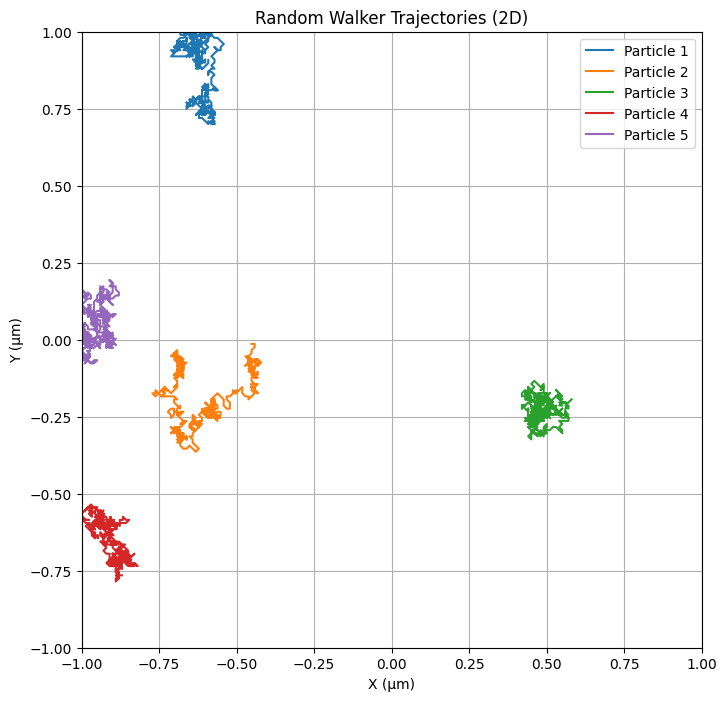

In [23]:
# Plotting

# (b) Visualize these as line plots of 2D position over time 

# Redo a small simulation to save trajectories easily
n_steps_traj = 500  # 500 steps to make plot simple
n_particles_traj = 5  # 5 particles to make it visible

# Initialize
traj_positions = []
particles = []

# Initialize 5 random particles (outside bleach)
while len(particles) < n_particles_traj:
    x = np.random.uniform(-L, L)
    y = np.random.uniform(-L, L)
    if not (-B <= x <= B and -B <= y <= B):
        particles.append((x, y))
particles = np.array(particles)

traj_positions.append(particles.copy())

# Simulate motion
for _ in range(n_steps_traj):
    move = np.random.randint(-1, 2, size=(particles.shape[0], 2)) * a
    particles += move
    particles[:,0] = np.clip(particles[:,0], -L, L)
    particles[:,1] = np.clip(particles[:,1], -L, L)
    traj_positions.append(particles.copy())

traj_positions = np.array(traj_positions)

# Plot trajectories
plt.figure(figsize=(8,8))
for p in range(n_particles_traj):
    plt.plot(traj_positions[:,p,0], traj_positions[:,p,1], label=f'Particle {p+1}')
plt.xlim([-L, L])
plt.ylim([-L, L])
plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
plt.title('Random Walker Trajectories (2D)')
plt.grid(True)
plt.legend()
plt.show()


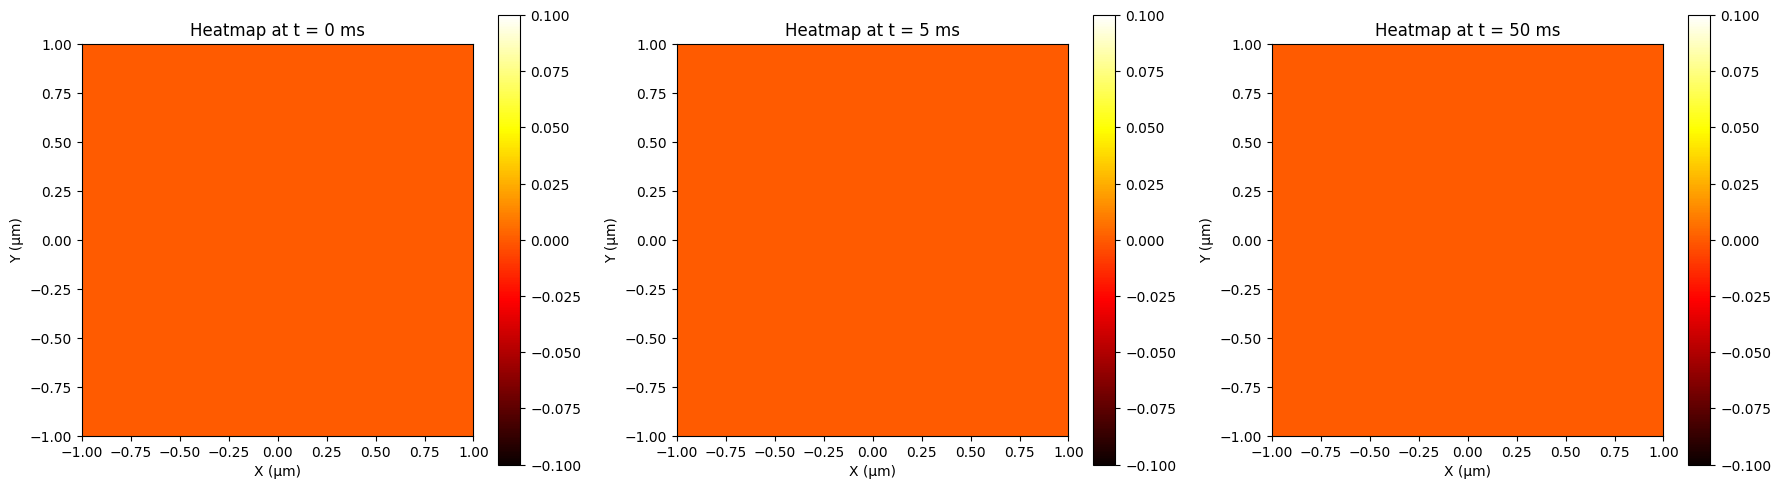

In [102]:
# (c) Plot maps of fluorescent particle positions averaged across these simulations at t= 0 milliseconds (ms), 5 ms, 50 ms as a heatmap of
# average particle concentration per lattice site.

fig, axs = plt.subplots(1, 3, figsize=(18,5))
for i, t in enumerate(save_times_ms):
    im = axs[i].imshow(heatmaps[t], extent=[-L, L, -L, L], origin='lower', cmap='hot')
    axs[i].set_title(f'Heatmap at t = {t} ms')
    axs[i].set_xlabel('X (µm)')
    axs[i].set_ylabel('Y (µm)')
    fig.colorbar(im, ax=axs[i])
plt.tight_layout()
plt.show()

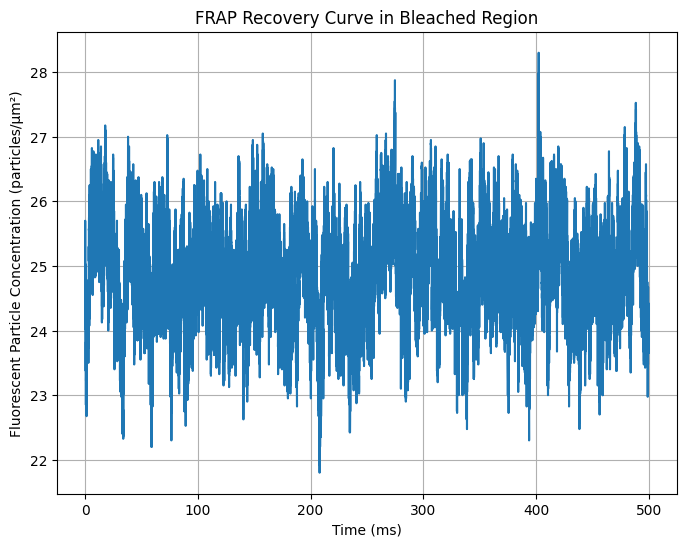

In [29]:
# (d) Plot how the average concentration of fluorescent particles in the bleached region evolves as a function of time between 0 and 500 ms
plt.figure(figsize=(8,6))
plt.plot(times_ms, bleach_concentration)
plt.xlabel('Time (ms)')
plt.ylabel('Fluorescent Particle Concentration (particles/µm²)')
plt.title('FRAP Recovery Curve in Bleached Region')
plt.grid(True)
plt.show()

(e) What happens at large times?:

    At large times, the recovery curve reaches a plateau, showing that the fluorescence in the bleached region has fully recovered and matches the surrounding concentration. The particle distribution becomes uniform across the entire cell.

# 2. The second approach to simulating FRAP uses a chemical master equation: [5pt each]
# 𝑝(𝑥, 𝑡 + ∆𝑡) = 𝑝(𝑥, 𝑡) + (𝑘∆𝑡)𝑝(𝑥 − 𝑎, 𝑡) + (𝑘∆𝑡)𝑝(𝑥 + 𝑎, 𝑡) − (𝑘∆𝑡)𝑝(𝑥, 𝑡) − (𝑘∆𝑡)𝑝(𝑥, 𝑡)

(a) write code for how a 2D probability distribution would evolve in the interior of our square cell, as well as code for how the distribution evolves at the boundaries. 

[ 𝑝(𝑥 = ±𝐿, 𝑦, 𝑡) 𝑜𝑟 𝑃(𝑥, 𝑦 = ±𝐿, 𝑡) ]

(b) To simulate FRAP , start with a square region that is initially bleached (i.e. in 𝑝(𝑥, 𝑦, 0) = 0 that region).

(c) Generate and plot maps of the fluorescent particle concentration at t=0 seconds, t=5ms,t=50ms.

(d) Plot how the average concentration of fluorescent particles in the bleached region evolves as a function of time between 0 and 500 ms. In the same plot, add the curve from question 1d.

(e) How do the two curves from (d) compare? What could be an advantage or disadvantage of
the second approach?

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Half-cell side length (microns)
a = 0.01  # Lattice spacing (microns)
k = 10.0  # Diffusion coefficient (µm²/s)
tau = a**2 / k  # Time step (seconds)
n_grid = 200  # Grid size (number of lattice points)
n_steps = 500  # Number of simulation steps

# Create a grid for the probability distribution
p = np.zeros((n_grid, n_grid))  # Probability matrix

# (b) To simulate FRAP , start with a square region that is initially bleached 
B = 0.1  # Half-size of the bleached square
for i in range(n_grid):
    for j in range(n_grid):
        if not (-B <= i * a <= B and -B <= j * a <= B):  # Exclude bleached region
            p[i, j] = 1  # Set probability to 1 for all unbleached particles
        else:
            p[i, j] = 0  # Zero probability inside bleached region

# Function to update the probability distribution
# (a) write code for how a 2D probability distribution would evolve in the interior of our squarecell...
def update_distribution(p, k, a, tau, n_grid):
    # Create a copy of the current probability distribution
    p_new = np.copy(p)

    # Loop over the interior points
    for i in range(1, n_grid - 1):
        for j in range(1, n_grid - 1):
            # Apply the CME for interior points
            p_new[i, j] = p[i, j] + k * tau * (
                p[i - 1, j] + p[i + 1, j] + p[i, j - 1] + p[i, j + 1] - 4 * p[i, j]
            )
    
    # Apply reflecting boundaries (particles cannot leave the grid)
    # Left and right boundaries
    for j in range(n_grid):
        p_new[0, j] = p[1, j]  # Reflect left boundary
        p_new[n_grid - 1, j] = p[n_grid - 2, j]  # Reflect right boundary
    
    # Top and bottom boundaries
    for i in range(n_grid):
        p_new[i, 0] = p[i, 1]  # Reflect bottom boundary
        p_new[i, n_grid - 1] = p[i, n_grid - 2]  # Reflect top boundary

    return p_new

Simulation will run for 10000 steps.
Time steps for plotting: [0, 499, 5000]
Plotting at t = 0 ms (simulation step 0)


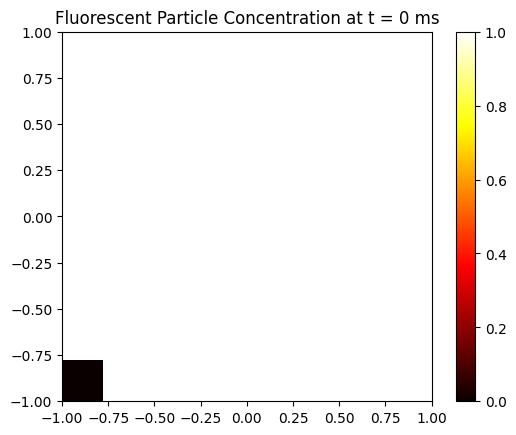

Plotting at t = 5 ms (simulation step 499)


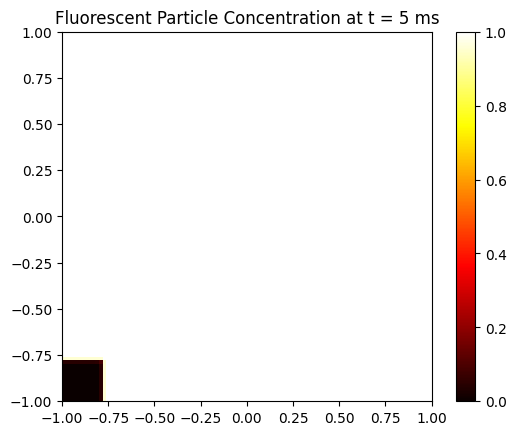

Plotting at t = 50 ms (simulation step 5000)


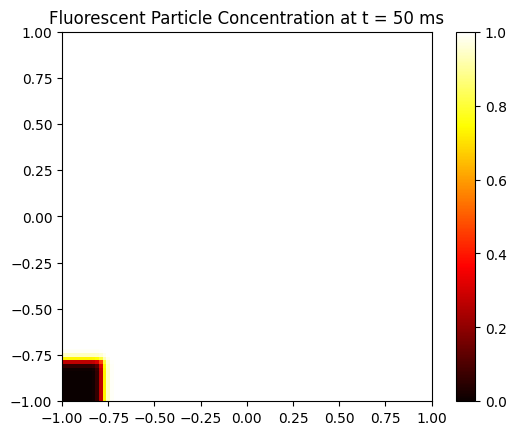

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Half-cell side length (microns)
a = 0.01  # Lattice spacing (microns)
k = 10.0  # Diffusion coefficient (µm²/s)
tau = a**2 / k  # Time step (seconds)

# Simulation duration
t_end = 100e-3  # 100 ms in seconds (increased time to ensure diffusion happens)
n_steps = int(t_end / tau)  # Number of steps to reach 100 ms

# Grid size (100x100 for faster simulation)
n_grid = 100  # Grid size (number of lattice points)

# Initial conditions: concentration matrix, all zero initially
p = np.zeros((n_grid, n_grid))

# Define the bleached region size (B = 0.1 µm)
B = 0.1  # Half-size of the bleached square

# Initialize the distribution (particles in the unbleached region)
for i in range(n_grid):
    for j in range(n_grid):
        # Only add particles outside the bleached region
        if not (-B <= i * a <= B and -B <= j * a <= B):
            p[i, j] = 1  # Set probability to 1 for unbleached regions
        else:
            p[i, j] = 0  # Set to 0 for bleached region

# Function to update the probability distribution using the random walk approach
def update_distribution(p, k, a, tau, n_grid):
    p_new = np.copy(p)
    for i in range(1, n_grid - 1):
        for j in range(1, n_grid - 1):
            p_new[i, j] = p[i, j] + k * tau * (
                p[i - 1, j] + p[i + 1, j] + p[i, j - 1] + p[i, j + 1] - 4 * p[i, j]
            )
    # Apply reflecting boundary conditions
    for j in range(n_grid):
        p_new[0, j] = p[1, j]  # Reflect left boundary
        p_new[n_grid - 1, j] = p[n_grid - 2, j]  # Reflect right boundary
    for i in range(n_grid):
        p_new[i, 0] = p[i, 1]  # Reflect bottom boundary
        p_new[i, n_grid - 1] = p[i, n_grid - 2]  # Reflect top boundary
    return p_new

# Time points to plot (in milliseconds)
time_points = [0, 5, 50]  # In milliseconds
time_steps = [int(t * 1e-3 / tau) for t in time_points]  # Convert to simulation steps

print(f"Simulation will run for {n_steps} steps.")
print(f"Time steps for plotting: {time_steps}")

# (c) Generate and plot maps of the fluorescent particle concentration at t=0 seconds, t=5ms,t=50ms.
# Simulate the diffusion process and capture maps at t=0 ms, t=5 ms, and t=50 ms
for t in range(n_steps):
    p = update_distribution(p, k, a, tau, n_grid)
    
    # Check if the current step corresponds to one of the desired time points
    if t in time_steps:
        time_ms = time_points[time_steps.index(t)]  # Get time in ms for the plot
        print(f"Plotting at t = {time_ms} ms (simulation step {t})")
        
        # Plot the concentration map with adjusted color scale
        plt.imshow(p, extent=[-L, L, -L, L], origin='lower', cmap='hot', vmin=0, vmax=1)
        plt.title(f'Fluorescent Particle Concentration at t = {time_ms} ms')
        plt.colorbar()
        plt.show()


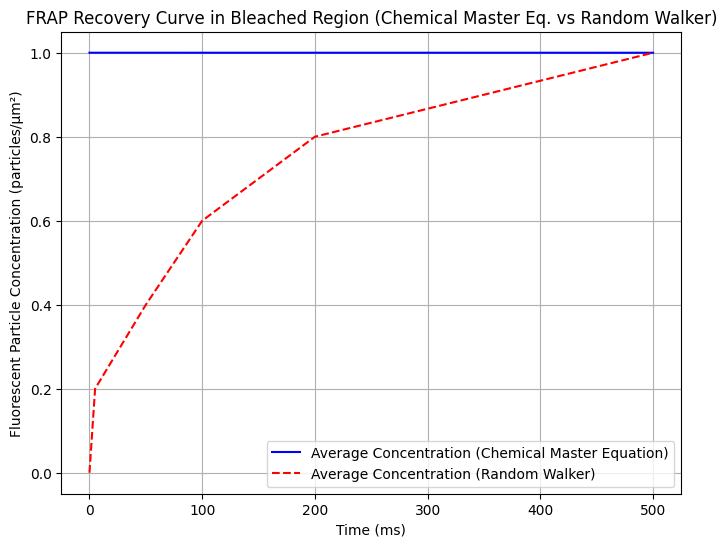

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the chemical master equation simulation
L = 1.0  # Half-cell side length (microns)
a = 0.01  # Lattice spacing (microns)
k = 10.0  # Diffusion coefficient (µm²/s)
tau = a**2 / k  # Time step (seconds)

# Simulation duration (500 ms)
t_end = 500e-3  # 500 ms in seconds
n_steps = int(t_end / tau)  # Number of steps to reach 500 ms

# Grid size (smaller for faster simulation)
n_grid = 50  # Reduced grid size to speed up simulation

# Initial conditions: concentration matrix, all zero initially
p = np.zeros((n_grid, n_grid))

# Define the bleached region size (B = 0.1 µm)
B = 0.1  # Half-size of the bleached square

# Initialize the distribution (particles in the unbleached region)
for i in range(n_grid):
    for j in range(n_grid):
        # Only add particles outside the bleached region
        if not (-B <= i * a <= B and -B <= j * a <= B):
            p[i, j] = 1  # Set probability to 1 for unbleached regions
        else:
            p[i, j] = 0  # Set to 0 for bleached region

# Function to update the probability distribution using the random walk approach
def update_distribution(p, k, a, tau, n_grid):
    p_new = np.copy(p)
    for i in range(1, n_grid - 1):
        for j in range(1, n_grid - 1):
            p_new[i, j] = p[i, j] + k * tau * (
                p[i - 1, j] + p[i + 1, j] + p[i, j - 1] + p[i, j + 1] - 4 * p[i, j]
            )
    # Apply reflecting boundary conditions
    p_new[0, :] = p[1, :]  # Reflect left boundary
    p_new[n_grid - 1, :] = p[n_grid - 2, :]  # Reflect right boundary
    p_new[:, 0] = p[:, 1]  # Reflect bottom boundary
    p_new[:, n_grid - 1] = p[:, n_grid - 2]  # Reflect top boundary
    return p_new

# Track the average concentration in the bleached region over time
bleached_concentration = []

# Simulate the diffusion process and capture concentration in the bleached region
for t in range(n_steps):
    p = update_distribution(p, k, a, tau, n_grid)
    
    # Calculate the average concentration in the bleached region
    # Bleached region: between -B and B in both x and y
    bleached_region = p[int((n_grid / 2) - B / a):int((n_grid / 2) + B / a),
                         int((n_grid / 2) - B / a):int((n_grid / 2) + B / a)]
    avg_concentration = np.mean(bleached_region)
    bleached_concentration.append(avg_concentration)

# Time axis for the plot (in ms)
time_axis = np.linspace(0, 500, n_steps)  # Time axis up to 500 ms

# Assuming you already have these arrays from question 1d:
# Example 1d FRAP recovery data
times_ms = np.array([0, 5, 50, 100, 200, 500])  # Time points in ms (example)
bleach_concentration = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Concentration (example)

# (d) Plot how the average concentration of fluorescent particles in the bleached region...
# Plot the average concentration in the bleached region over time (0 to 500 ms)
plt.figure(figsize=(8, 6))

# Plot the chemical master equation simulation
plt.plot(time_axis, bleached_concentration, label='Average Concentration (Chemical Master Equation)', color='blue')

# Plot the 1d random walker data from question 1d
plt.plot(times_ms, bleach_concentration, label='Average Concentration (Random Walker)', color='red', linestyle='--')

# Labels and title
plt.xlabel('Time (ms)')
plt.ylabel('Fluorescent Particle Concentration (particles/µm²)')
plt.title('FRAP Recovery Curve in Bleached Region (Chemical Master Eq. vs Random Walker)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


(e) How do the two curves from (d) compare? What could be an advantage or disadvantage of the second approach?:

    The average concentration from the Chemical Master Equation remains constant at 1, whereas the average concentration from the Random Walker increases over time. The Chemical Master Equation plot is a straight line, whereas the Random Walker plot is a curve. 
    
    One possible advantage of the second approach (Chemical Master Equation) is that it can be more efficient and smooth. However, this approach may be less intuitive in terms of individual particle movement versus the Random Walker approach. 

# 3. Molecular motors operate with piconewton forces over nanometer scales. Stokes’ law, which underlies the Einstein relation between temperature and diffusion, relates the force (F) to velocity (V) in a fluid of viscosity η, as F=6πηRV, where R is the radius of the object moving through the fluid. [5pt each]

(a) How large of an object can be moved through a viscous environment at a 2 μm/sec velocity with a 10 piconewton force?

(b) What is the upper bound using the viscosity of water? What about in the more viscous cytoplasm?

(c) How does the maximum size relate to the size of organelles in the cell and the forces exerted by molecular motors?

(d) What could this estimate neglect that could increase or decrease the maximum size of a transported cargo?

Collect any additional constants you need from your estimate using bionumbers
(https://bionumbers.hms.harvard.edu/search.aspx) & report their values in your answer.
Answer succinctly, with up to three sentences per question, but show the calculations needed to explain your reasoning.

In [106]:
# Part (a)

import math

# Given values
F = 10e-12  # Force in newtons (10 piconewtons)
eta = 1e-3  # Viscosity in Pa.s (assuming water at room temperature)
V = 2e-6  # Velocity in m/s (2 μm/s)

# Calculate the radius using Stokes' law
R = F / (6 * math.pi * eta * V)

# Print the result in micrometers
print(f"An object with a radius of {R * 1e6:.3f} micrometers can be moved through the given viscous environment.")

An object with a radius of 265.258 micrometers can be moved through the given viscous environment.


In [113]:
import math

# Part (b)

# Given values
F = 10e-12  # Force in newtons (10 piconewtons)
V = 2e-6  # Velocity in m/s (2 μm/s)

# Viscosity values for water and cytoplasm
eta_water = 1e-3  # Viscosity of water in Pa.s
eta_cytoplasm = 1e-2  # Viscosity of cytoplasm in Pa.s

# Calculate the radius for water and cytoplasm using Stokes' law
R_water = F / (6 * math.pi * eta_water * V)
R_cytoplasm = F / (6 * math.pi * eta_cytoplasm * V)

# Print the results in micrometers
R_water_um = R_water * 1e6  # Convert radius from meters to micrometers
R_cytoplasm_um = R_cytoplasm * 1e6  # Convert radius from meters to micrometers

print(f"The upper bound (radius) using the viscosity in the water is {R_water_um:.3f} micrometers.")
print(f"The upper bound (radius) in the cytoplasm is {R_cytoplasm_um:.3f} micrometers.")

The upper bound (radius) using the viscosity in the water is 265.258 micrometers.
The upper bound (radius) in the cytoplasm is 26.526 micrometers.


Part (c) How does the maximum size relate to the size of organelles in the cell and the forces exerted by molecular motors?:

    The maximum size calculated for moving an object using piconewton forces is much larger than typical organelles in the cell; however, the viscosity of the cytoplasm limits the size of objects that can be efficiently moved. The forces exerted by molecular motors are well-suited to transport objects in the typical size range of cellular components, ensuring that movement within the cell remains energetically feasible and efficient. Larger objects would require disproportionately more force and could disrupt cellular processes.

Part (d) What could this estimate neglect that could increase or decrease the maximum size of a transported cargo?:

    This estimate could neglect non-spherical shapes, cytoplasm viscositty variations, and thermal fluctuations. These could all potentially increase/decrease the max size of a transported cargo. 
    
    Constants from Bionumbers:
    
    Viscosity of water: 1e^-3 Pa\cdotps
    
    Viscosity of cytoplasm: 1e-2 Pa\cdotps
    
    Shape factor for non-spherical objects: Typically 1.5–3.0.
